In this notebook, we built several models with 'app_train.csv'.

The classification algorithms used are Logistic Regression, Random Forest Classifier, LGBM Classifier and XGB Classifier.

To solve the problem of imbalanced data, we tested 3 methods:
- RandomUnderSampling
- RandomOverSampling
- SMOTE

In this notebook, we have not applied cross validation to speed up the process.

For each model, AUC was calculated for test and training sets, precision and recall for test set. The confusion matrix and graphs showing the most important variables were also displayed.

Remark: RandomForestClassifier overfit (AUC for training set equal to 1 and AUC for test set is not as great).

# 1. Imports

In [1]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer
from imblearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectFromModel
import re

# 2. Load Data

In [2]:
app_train = pd.read_csv('app_train.csv')

In [3]:
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

In [4]:
sns.set_theme(style='darkgrid')

# 3. Model

In [5]:
train = app_train.copy()

In [6]:
# Extract the ids
train_ids = train['SK_ID_CURR']
    
# Extract the labels for training
labels = train['TARGET']
    
# Remove the ids and target
train = train.drop(columns = ['SK_ID_CURR', 'TARGET'])

In [7]:
categorical_features_1 = []
categorical_features_2 = []

for col in train.select_dtypes(['object', 'bool']):
    if len(list(train[col].unique())) <= 2:
        categorical_features_1.append(col)
    else:
        categorical_features_2.append(col)

In [8]:
numerical_features = train.select_dtypes(['float64', 'int64']).columns.tolist()

In [9]:
numerical_pipeline = make_pipeline(SimpleImputer(strategy='median'), MinMaxScaler(feature_range=(0, 1)))
categorical_pipeline_1 = make_pipeline(SimpleImputer(strategy='constant', fill_value='Missing'), OrdinalEncoder())
categorical_pipeline_2 = make_pipeline(SimpleImputer(strategy='constant', fill_value='Missing'), OneHotEncoder(handle_unknown='ignore'))

In [10]:
preprocessor = make_column_transformer((numerical_pipeline, numerical_features), (categorical_pipeline_1, categorical_features_1), (categorical_pipeline_2, categorical_features_2))

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(train, labels, test_size=0.20, random_state=42)

In [12]:
def conf_matrix(y_test, pred):
    con_mat = confusion_matrix(y_test, pred)
    con_mat = pd.DataFrame(con_mat, range(2), range(2))
    plt.figure(figsize=(4, 4))
    plt.title('Confusion Matrix', size=15)
    sns.heatmap(con_mat, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

In [13]:
def get_column_names_from_ColumnTransformer(column_transformer):
    """
    Helper function which explores a Column Transformer to get feature names
    Parameters
    ----------
    column_transformer: a sklearn column_transformer
    Returns
    ----------
    a list of strings of the column names of the outputs of the colun_transformer
    """
    col_name = []
    for transformer_in_columns in column_transformer.transformers_:
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1], Pipeline):
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        if isinstance(transformer, OneHotEncoder):
            if isinstance(raw_col_name, str):
                names = transformer.get_feature_names(input_features=[raw_col_name])
            else:
                names = transformer.get_feature_names(input_features=raw_col_name)
        elif isinstance(transformer, PolynomialFeatures):
            names = transformer.get_feature_names(input_features=raw_col_name)
        else:
            try:
                names = transformer.get_feature_names()
            except AttributeError:
                # if no 'get_feature_names' function, use raw column name
                names = raw_col_name
        if isinstance(names, np.ndarray):  # eg.
            col_name += names.tolist()
        elif isinstance(names, list):
            col_name += names
        elif isinstance(names, str):
            col_name.append(names)
    return col_name

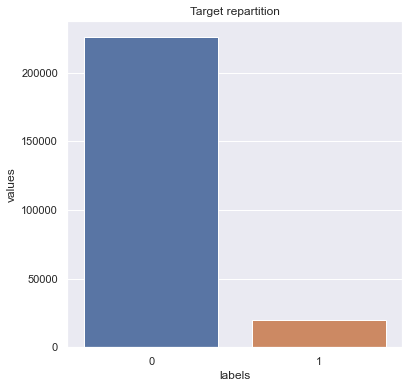

In [14]:
temp = Y_train.value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
plt.figure(figsize = (6,6))
plt.title('Target repartition')
sns.set_color_codes('pastel')
sns.barplot(x='labels', y='values', data=df)
locs, labels = plt.xticks()
plt.show()

### 3.1. Logistic Regression

#### With Under Sampling

In [15]:
rus = RandomUnderSampler(random_state=42)
X_train_rus, Y_train_rus = rus.fit_resample(X_train, Y_train)

In [16]:
model_lr = make_pipeline(preprocessor, SelectFromModel(XGBClassifier()), LogisticRegression(random_state=42))

In [17]:
model_lr.fit(X_train_rus, Y_train_rus)
pred_1 = model_lr.predict_proba(X_test)
pred_1 = pred_1[:, 1]

[17:01:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [18]:
auc_1 = roc_auc_score(Y_test, pred_1)
print('AUC: ', auc_1)

AUC:  0.7465161552028448


In [19]:
pred_1_t = model_lr.predict_proba(X_train_rus)
pred_1_t = pred_1_t[:, 1]
auc_1_t = roc_auc_score(Y_train_rus, pred_1_t)
print('AUC: ', auc_1_t)

AUC:  0.7480208318947165


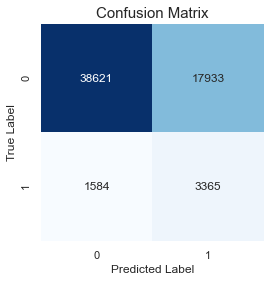

In [20]:
pred_test = model_lr.predict(X_test)
conf_matrix(Y_test, pred_test)

In [21]:
precision_1 = precision_score(Y_test, pred_test)
recall_1 = recall_score(Y_test, pred_test)

print('precision: ', precision_1)
print('recall: ', recall_1)

precision:  0.1579960559676965
recall:  0.6799353404728228


In [22]:
mask = model_lr['selectfrommodel'].get_support()
new_features = []

for bool, feature in zip(mask, get_column_names_from_ColumnTransformer(model_lr['columntransformer'])):
    if bool:
        new_features.append(feature)

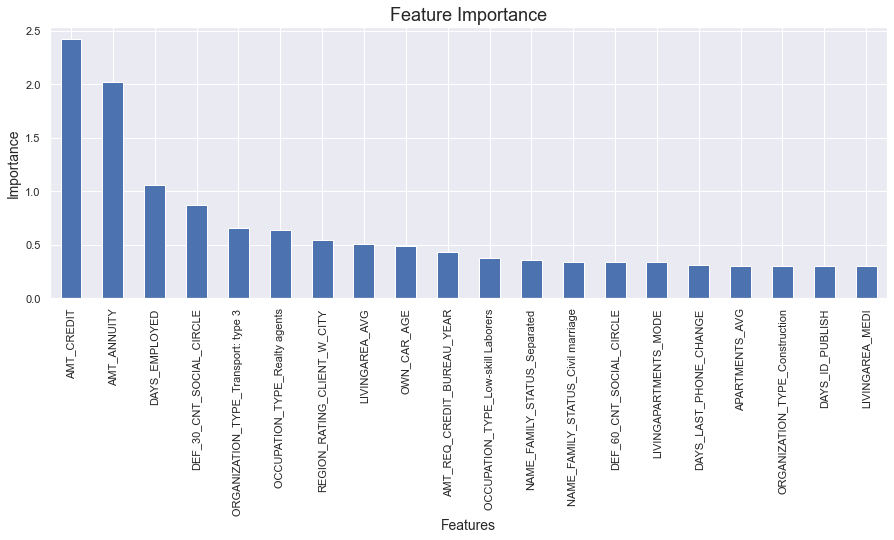

In [23]:
Importance = pd.DataFrame(model_lr['logisticregression'].coef_[0], index = new_features, columns = ['Importance'])
plt.figure(figsize = (15,5))
Importance['Importance'].sort_values(ascending = False)[:20].plot.bar(y = 'Importance')
plt.title('Feature Importance', fontsize = 18)
plt.xlabel('Features', size = 14)
plt.ylabel('Importance', size = 14)
plt.show()

#### With Over Sampling

In [24]:
ros = RandomOverSampler(random_state=42)
X_train_ros, Y_train_ros = ros.fit_resample(X_train, Y_train)

In [25]:
model_lr = make_pipeline(preprocessor, SelectFromModel(XGBClassifier()), LogisticRegression(random_state=42))

In [26]:
model_lr.fit(X_train_ros, Y_train_ros)
pred_2 = model_lr.predict_proba(X_test)
pred_2 = pred_2[:, 1]

[17:02:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [27]:
auc_2 = roc_auc_score(Y_test, pred_2)
print('AUC: ', auc_2)

AUC:  0.7470226082895983


In [28]:
pred_2_t = model_lr.predict_proba(X_train_ros)
pred_2_t = pred_2_t[:, 1]
auc_2_t = roc_auc_score(Y_train_ros, pred_2_t)
print('AUC: ', auc_2_t)

AUC:  0.748261629599439


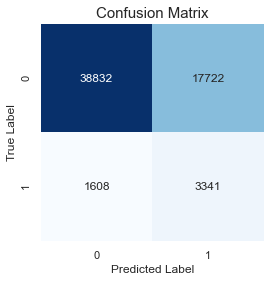

In [29]:
pred_test = model_lr.predict(X_test)
conf_matrix(Y_test, pred_test)

In [30]:
precision_2 = precision_score(Y_test, pred_test)
recall_2 = recall_score(Y_test, pred_test)

print('precision: ', precision_2)
print('recall: ', recall_2)

precision:  0.15861937995537198
recall:  0.6750858759345322


In [31]:
mask = model_lr['selectfrommodel'].get_support()
new_features = []

for bool, feature in zip(mask, get_column_names_from_ColumnTransformer(model_lr['columntransformer'])):
    if bool:
        new_features.append(feature)

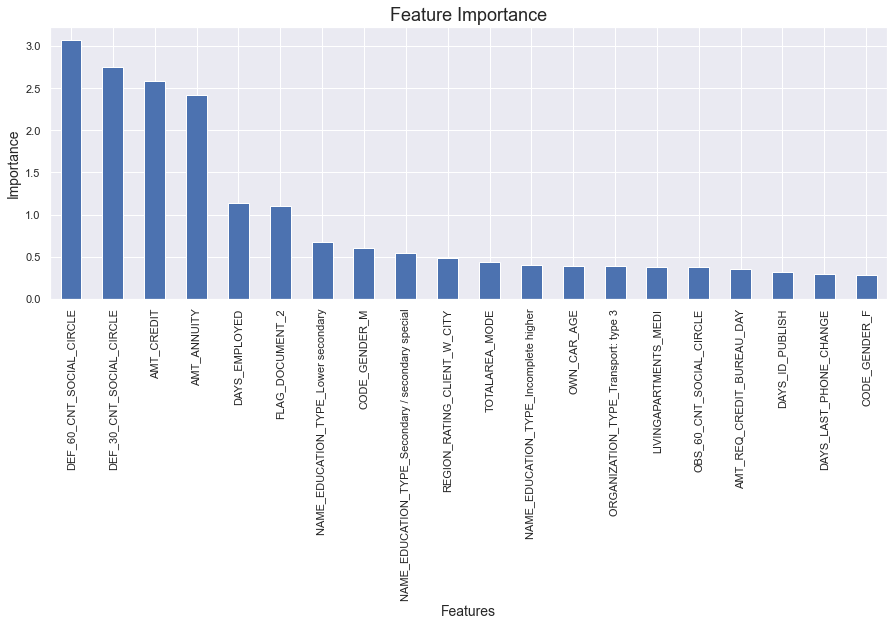

In [32]:
Importance = pd.DataFrame(model_lr['logisticregression'].coef_[0], index = new_features, columns = ['Importance'])
plt.figure(figsize = (15,5))
Importance['Importance'].sort_values(ascending = False)[:20].plot.bar(y = 'Importance')
plt.title('Feature Importance', fontsize = 18)
plt.xlabel('Features', size = 14)
plt.ylabel('Importance', size = 14)
plt.show()

#### With SMOTE

In [33]:
X_train_smo = preprocessor.fit_transform(X_train)
X_test_smo = preprocessor.fit_transform(X_test)

In [34]:
X_train_smo = pd.DataFrame(X_train_smo, columns=get_column_names_from_ColumnTransformer(preprocessor))
X_test_smo = pd.DataFrame(X_test_smo, columns=get_column_names_from_ColumnTransformer(preprocessor))

In [35]:
smo = SMOTE(random_state=42)
X_train_smo, Y_train_smo = smo.fit_resample(X_train_smo, Y_train)

In [36]:
model_lr = make_pipeline(SelectFromModel(XGBClassifier()), LogisticRegression(random_state=42))

In [37]:
model_lr.fit(X_train_smo, Y_train_smo)
pred_3 = model_lr.predict_proba(X_test_smo)
pred_3 = pred_3[:, 1]

[17:04:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [38]:
auc_3 = roc_auc_score(Y_test, pred_3)
print('AUC: ', auc_3)

AUC:  0.7294072989340443


In [39]:
pred_3_t = model_lr.predict_proba(X_train_smo)
pred_3_t = pred_3_t[:, 1]
auc_3_t = roc_auc_score(Y_train_smo, pred_3_t)
print('AUC: ', auc_3_t)

AUC:  0.7645775619340851


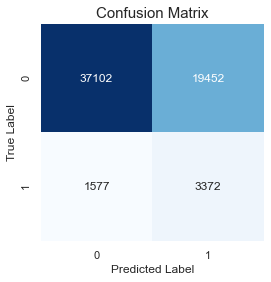

In [40]:
pred_test = model_lr.predict(X_test_smo)
conf_matrix(Y_test, pred_test)

In [41]:
precision_3 = precision_score(Y_test, pred_test)
recall_3 = recall_score(Y_test, pred_test)

print('precision: ', precision_3)
print('recall: ', recall_3)

precision:  0.14773922187171398
recall:  0.6813497676298242


In [42]:
mask = model_lr['selectfrommodel'].get_support()
new_features = []

for bool, feature in zip(mask, get_column_names_from_ColumnTransformer(preprocessor)):
    if bool:
        new_features.append(feature)

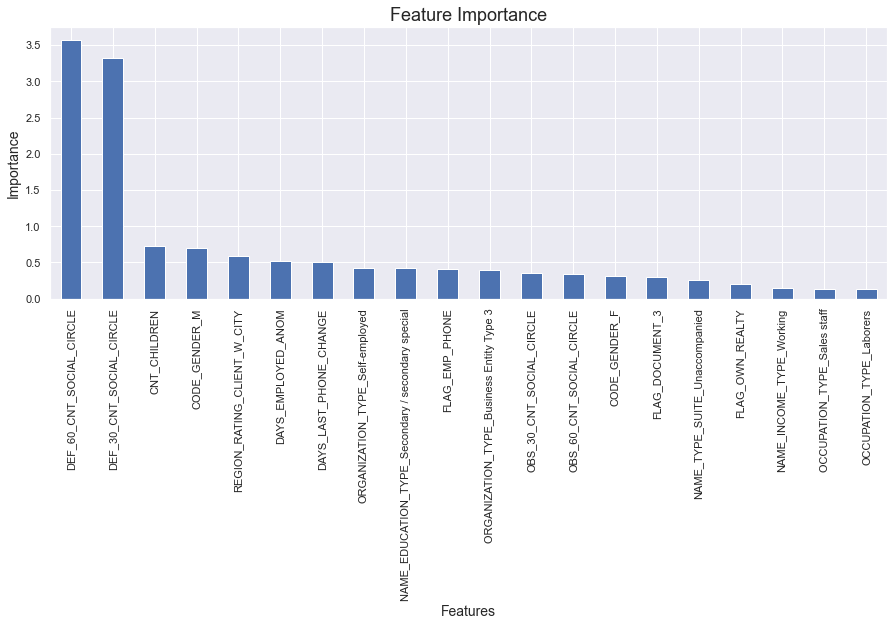

In [43]:
Importance = pd.DataFrame(model_lr['logisticregression'].coef_[0], index=new_features, columns=['Importance'])
plt.figure(figsize=(15, 5))
Importance['Importance'].sort_values(ascending=False)[:20].plot.bar(y='Importance')
plt.title('Feature Importance', fontsize=18)
plt.xlabel('Features', size=14)
plt.ylabel('Importance', size=14)
plt.show()

### 3.2. Random Forest Classifier

#### With Under Sampling

In [44]:
model_rfc = make_pipeline(preprocessor, SelectFromModel(XGBClassifier()), RandomForestClassifier(random_state=42))

In [45]:
model_rfc.fit(X_train_rus, Y_train_rus)
pred_4 = model_rfc.predict_proba(X_test)
pred_4 = pred_4[:, 1]

[17:06:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [46]:
auc_4 = roc_auc_score(Y_test, pred_4)
print('AUC: ', auc_4)

AUC:  0.7373085319607523


In [47]:
pred_4_t = model_rfc.predict_proba(X_train_rus)
pred_4_t = pred_4_t[:, 1]
auc_4_t = roc_auc_score(Y_train_rus, pred_4_t)
print('AUC: ', auc_4_t)

AUC:  1.0


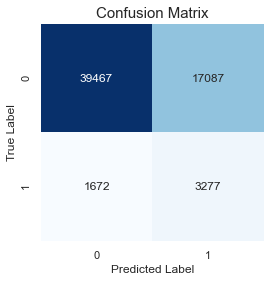

In [48]:
pred_test = model_rfc.predict(X_test)
conf_matrix(Y_test, pred_test)

In [49]:
precision_4 = precision_score(Y_test, pred_test)
recall_4 = recall_score(Y_test, pred_test)

print('precision: ', precision_4)
print('recall: ', recall_4)

precision:  0.1609212335494009
recall:  0.6621539704990907


In [50]:
mask = model_rfc['selectfrommodel'].get_support()
new_features = []

for bool, feature in zip(mask, get_column_names_from_ColumnTransformer(model_rfc['columntransformer'])):
    if bool:
        new_features.append(feature)

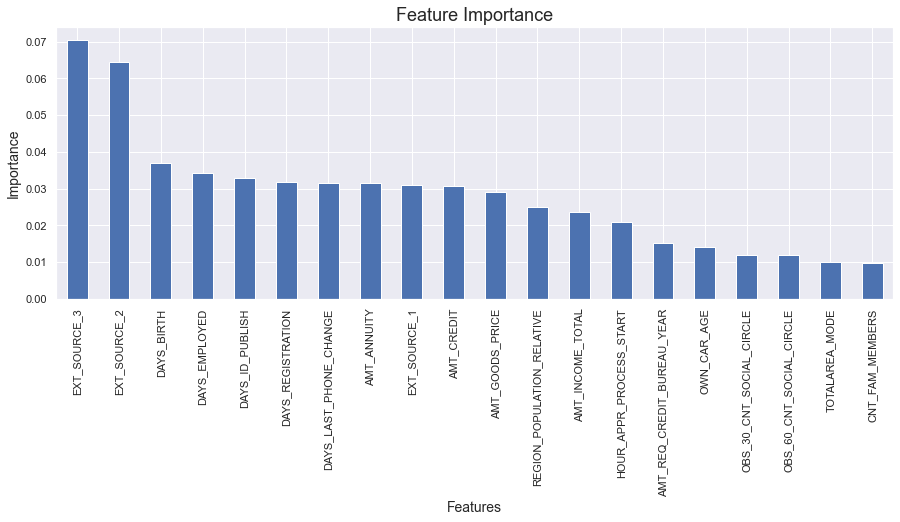

In [51]:
Importance = pd.DataFrame(model_rfc['randomforestclassifier'].feature_importances_, index = new_features, columns = ['Importance'])
plt.figure(figsize=(15, 5))
Importance['Importance'].sort_values(ascending = False)[:20].plot.bar(y = 'Importance')
plt.title('Feature Importance', fontsize = 18)
plt.xlabel('Features', size = 14)
plt.ylabel('Importance', size = 14)
plt.show()

#### With Over Sampling

In [52]:
model_rfc = make_pipeline(preprocessor, SelectFromModel(XGBClassifier()), RandomForestClassifier(random_state=42))

In [53]:
model_rfc.fit(X_train_ros, Y_train_ros)
pred_5 = model_rfc.predict_proba(X_test)
pred_5 = pred_5[:, 1]

[17:07:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [54]:
auc_5 = roc_auc_score(Y_test, pred_5)
print('AUC: ', auc_5)

AUC:  0.7297580634920937


In [55]:
pred_5_t = model_rfc.predict_proba(X_train_ros)
pred_5_t = pred_5_t[:, 1]
auc_5_t = roc_auc_score(Y_train_ros, pred_5_t)
print('AUC: ', auc_5_t)

AUC:  1.0


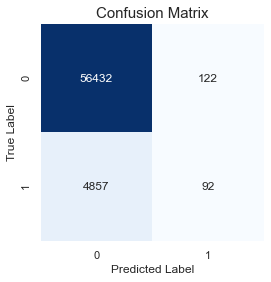

In [56]:
pred_test = model_rfc.predict(X_test)
conf_matrix(Y_test, pred_test)

In [57]:
precision_5 = precision_score(Y_test, pred_test)
recall_5 = recall_score(Y_test, pred_test)

print('precision: ', precision_5)
print('recall: ', recall_5)

precision:  0.42990654205607476
recall:  0.01858961406344716


In [58]:
mask = model_rfc['selectfrommodel'].get_support()
new_features = []

for bool, feature in zip(mask, get_column_names_from_ColumnTransformer(model_rfc['columntransformer'])):
    if bool:
        new_features.append(feature)

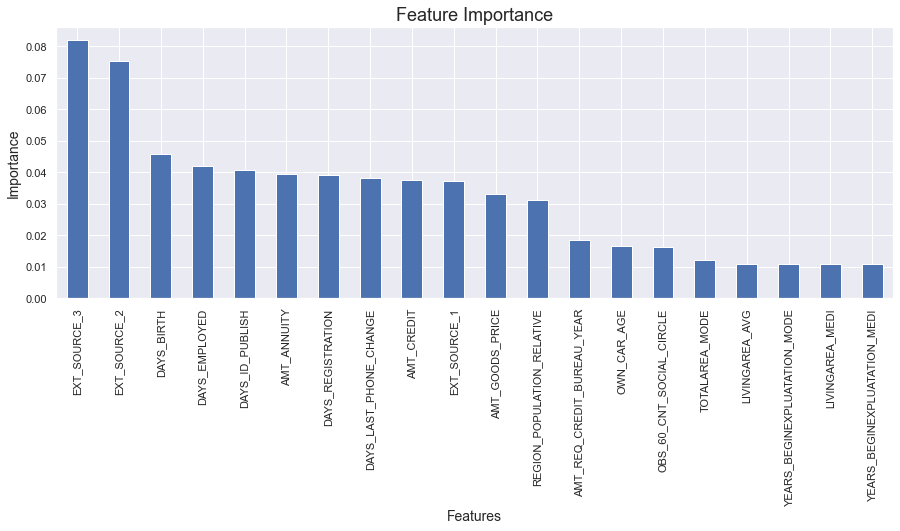

In [59]:
Importance = pd.DataFrame(model_rfc['randomforestclassifier'].feature_importances_, index = new_features, columns = ['Importance'])
plt.figure(figsize=(15, 5))
Importance['Importance'].sort_values(ascending = False)[:20].plot.bar(y = 'Importance')
plt.title('Feature Importance', fontsize = 18)
plt.xlabel('Features', size = 14)
plt.ylabel('Importance', size = 14)
plt.show()

#### With SMOTE

In [60]:
model_rfc = make_pipeline(SelectFromModel(XGBClassifier()), RandomForestClassifier(random_state=42))

In [61]:
model_rfc.fit(X_train_smo, Y_train_smo)
pred_6 = model_rfc.predict_proba(X_test_smo)
pred_6 = pred_6[:, 1]

[17:12:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [62]:
auc_6 = roc_auc_score(Y_test, pred_6)
print('AUC: ', auc_6)

AUC:  0.6778839891331944


In [63]:
pred_6_t = model_rfc.predict_proba(X_train_smo)
pred_6_t = pred_6_t[:, 1]
auc_6_t = roc_auc_score(Y_train_smo, pred_6_t)
print('AUC: ', auc_6_t)

AUC:  1.0


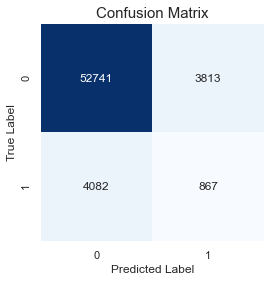

In [64]:
pred_test = model_rfc.predict(X_test_smo)
conf_matrix(Y_test, pred_test)

In [65]:
precision_6 = precision_score(Y_test, pred_test)
recall_6 = recall_score(Y_test, pred_test)

print('precision: ', precision_6)
print('recall: ', recall_6)

precision:  0.18525641025641026
recall:  0.1751869064457466


In [66]:
mask = model_rfc['selectfrommodel'].get_support()
new_features = []

for bool, feature in zip(mask, get_column_names_from_ColumnTransformer(preprocessor)):
    if bool:
        new_features.append(feature)

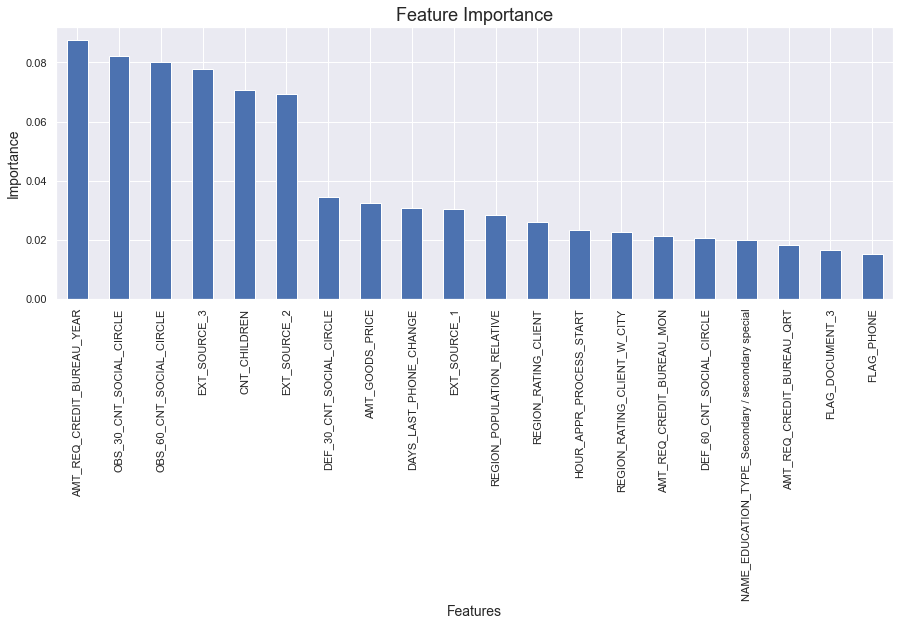

In [67]:
Importance = pd.DataFrame(model_rfc['randomforestclassifier'].feature_importances_, index = new_features, columns = ['Importance'])
plt.figure(figsize=(15, 5))
Importance['Importance'].sort_values(ascending = False)[:20].plot.bar(y = 'Importance')
plt.title('Feature Importance', fontsize = 18)
plt.xlabel('Features', size = 14)
plt.ylabel('Importance', size = 14)
plt.show()

### 3.3. LGBMClassifier

#### With Under Sampling

In [68]:
model_lgbmc = make_pipeline(preprocessor, SelectFromModel(XGBClassifier()), LGBMClassifier(random_state=42))

In [69]:
model_lgbmc.fit(X_train_rus, Y_train_rus)
pred_7 = model_lgbmc.predict_proba(X_test)
pred_7 = pred_7[:, 1]

[17:16:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [70]:
auc_7 = roc_auc_score(Y_test, pred_7)
print('AUC: ', auc_7)

AUC:  0.7552431591139336


In [71]:
pred_7_t = model_lgbmc.predict_proba(X_train_rus)
pred_7_t = pred_7_t[:, 1]
auc_7_t = roc_auc_score(Y_train_rus, pred_7_t)
print('AUC: ', auc_7_t)

AUC:  0.818522522776655


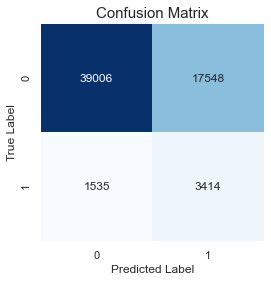

In [72]:
pred_test = model_lgbmc.predict(X_test)
conf_matrix(Y_test, pred_test)

In [73]:
precision_7 = precision_score(Y_test, pred_test)
recall_7 = recall_score(Y_test, pred_test)

print('precision: ', precision_7)
print('recall: ', recall_7)

precision:  0.1628661387272207
recall:  0.6898363305718327


In [74]:
mask = model_lgbmc['selectfrommodel'].get_support()
new_features = []

for bool, feature in zip(mask, get_column_names_from_ColumnTransformer(model_lgbmc['columntransformer'])):
    if bool:
        new_features.append(feature)

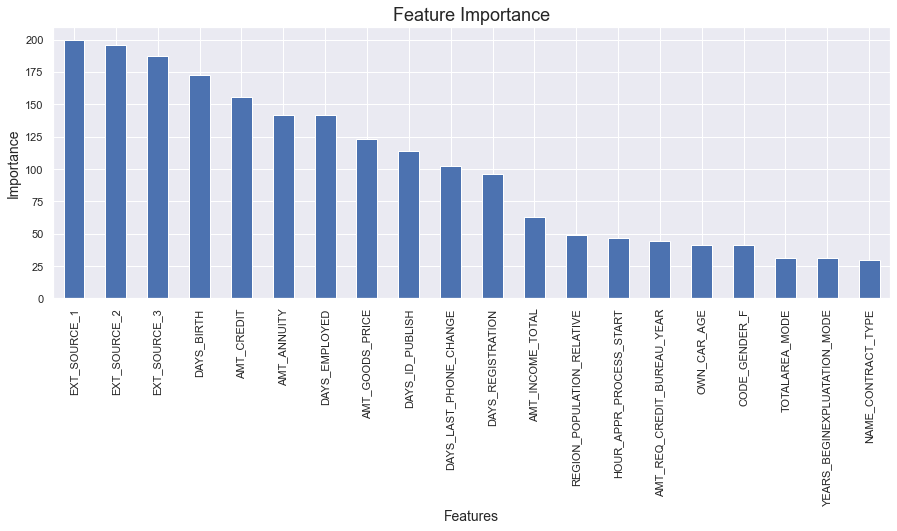

In [75]:
Importance = pd.DataFrame(model_lgbmc['lgbmclassifier'].feature_importances_, index = new_features, columns = ['Importance'])
plt.figure(figsize = (15,5))
Importance['Importance'].sort_values(ascending = False)[:20].plot.bar(y = 'Importance')
plt.title('Feature Importance', fontsize = 18)
plt.xlabel('Features', size = 14)
plt.ylabel('Importance', size = 14)
plt.show()

#### With Over Sampling

In [76]:
model_lgbmc = make_pipeline(preprocessor, SelectFromModel(XGBClassifier()), LGBMClassifier(random_state=42))

In [77]:
model_lgbmc.fit(X_train_ros, Y_train_ros)
pred_8 = model_lgbmc.predict_proba(X_test)
pred_8 = pred_8[:, 1]

[17:17:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [78]:
auc_8 = roc_auc_score(Y_test, pred_8)
print('AUC: ', auc_8)

AUC:  0.7596786118575685


In [79]:
pred_8_t = model_lgbmc.predict_proba(X_train_ros)
pred_8_t = pred_8_t[:, 1]
auc_8_t = roc_auc_score(Y_train_ros, pred_8_t)
print('AUC: ', auc_8_t)

AUC:  0.7970702375322276


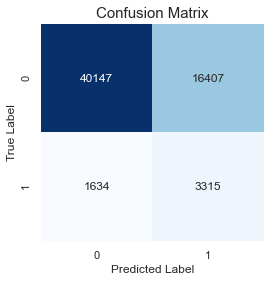

In [80]:
pred_test = model_lgbmc.predict(X_test)
conf_matrix(Y_test, pred_test)

In [81]:
precision_8 = precision_score(Y_test, pred_test)
recall_8 = recall_score(Y_test, pred_test)

print('precision: ', precision_8)
print('recall: ', recall_8)

precision:  0.16808640097353209
recall:  0.6698322893513842


In [82]:
mask = model_lgbmc['selectfrommodel'].get_support()
new_features = []

for bool, feature in zip(mask, get_column_names_from_ColumnTransformer(model_lgbmc['columntransformer'])):
    if bool:
        new_features.append(feature)

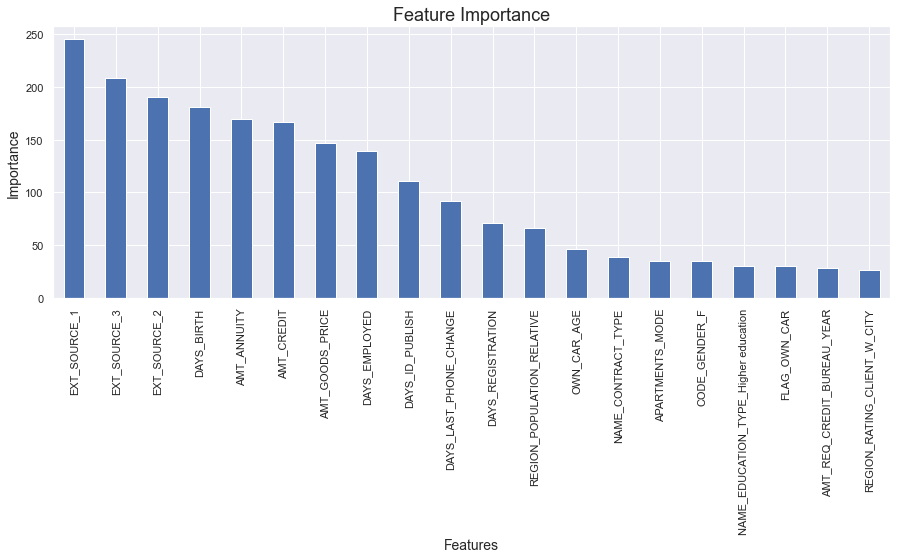

In [83]:
Importance = pd.DataFrame(model_lgbmc['lgbmclassifier'].feature_importances_, index = new_features, columns = ['Importance'])
plt.figure(figsize = (15,5))
Importance['Importance'].sort_values(ascending = False)[:20].plot.bar(y = 'Importance')
plt.title('Feature Importance', fontsize = 18)
plt.xlabel('Features', size = 14)
plt.ylabel('Importance', size = 14)
plt.show()

#### With SMOTE

In [84]:
model_lgbmc = make_pipeline(SelectFromModel(XGBClassifier()), LGBMClassifier(random_state=42))

In [85]:
X_train_smo_b = X_train_smo.copy()

In [86]:
X_train_smo_b = X_train_smo_b.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [87]:
model_lgbmc.fit(X_train_smo_b, Y_train_smo)
pred_9 = model_lgbmc.predict_proba(X_test_smo)
pred_9 = pred_9[:, 1]

[17:19:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [88]:
auc_9 = roc_auc_score(Y_test, pred_9)
print('AUC: ', auc_9)

AUC:  0.6636053984685595


In [89]:
pred_9_t = model_lgbmc.predict_proba(X_train_smo)
pred_9_t = pred_9_t[:, 1]
auc_9_t = roc_auc_score(Y_train_smo, pred_9_t)
print('AUC: ', auc_9_t)

AUC:  0.977909892260283


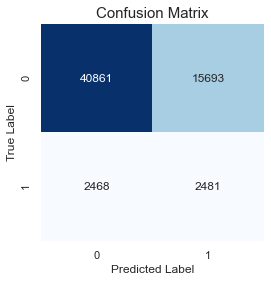

In [90]:
pred_test = model_lgbmc.predict(X_test_smo)
conf_matrix(Y_test, pred_test)

In [91]:
precision_9 = precision_score(Y_test, pred_test)
recall_9 = recall_score(Y_test, pred_test)

print('precision: ', precision_9)
print('recall: ', recall_9)

precision:  0.1365137008913833
recall:  0.501313396645787


In [92]:
mask = model_lgbmc['selectfrommodel'].get_support()
new_features = []

for bool, feature in zip(mask, get_column_names_from_ColumnTransformer(preprocessor)):
    if bool:
        new_features.append(feature)

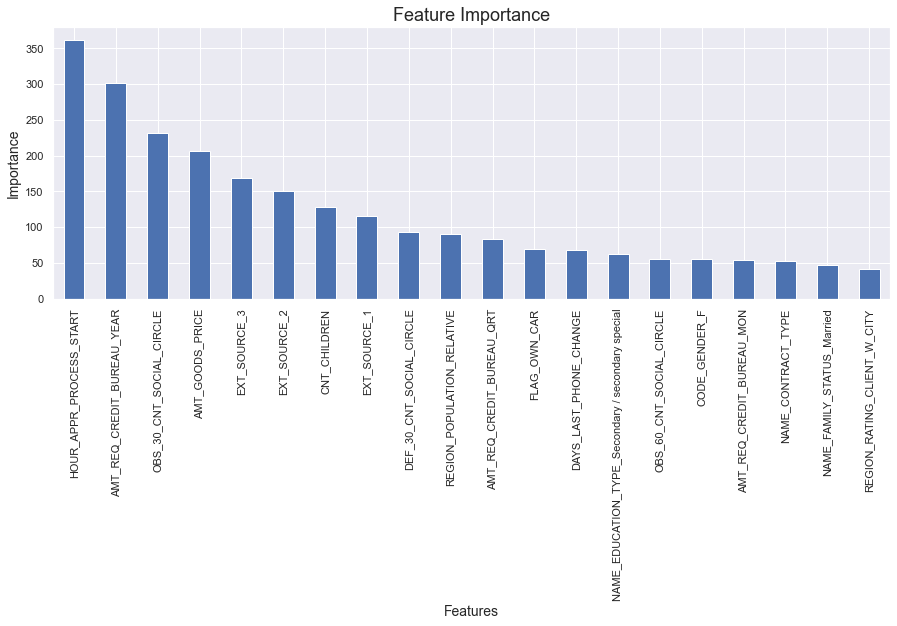

In [93]:
Importance = pd.DataFrame(model_lgbmc['lgbmclassifier'].feature_importances_, index=new_features, columns=['Importance'])
plt.figure(figsize=(15, 5))
Importance['Importance'].sort_values(ascending=False)[:20].plot.bar(y='Importance')
plt.title('Feature Importance', fontsize=18)
plt.xlabel('Features', size=14)
plt.ylabel('Importance', size=14)
plt.show()

### 3.4. XGBClassifier

#### With Under Sampling

In [94]:
model_xgbc = make_pipeline(preprocessor, SelectFromModel(XGBClassifier()), XGBClassifier(random_state=42))

In [95]:
model_xgbc.fit(X_train_rus, Y_train_rus)
pred_10 = model_xgbc.predict_proba(X_test)
pred_10 = pred_10[:, 1]

[17:21:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:21:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [96]:
auc_10 = roc_auc_score(Y_test, pred_10)
print('AUC: ', auc_10)

AUC:  0.7411747560020437


In [97]:
pred_10_t = model_xgbc.predict_proba(X_train_rus)
pred_10_t = pred_10_t[:, 1]
auc_10_t = roc_auc_score(Y_train_rus, pred_10_t)
print('AUC: ', auc_10_t)

AUC:  0.8987511107809858


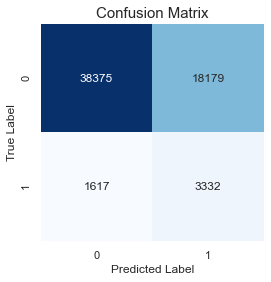

In [98]:
pred_test = model_xgbc.predict(X_test)
conf_matrix(Y_test, pred_test)

In [99]:
precision_10 = precision_score(Y_test, pred_test)
recall_10 = recall_score(Y_test, pred_test)

print('precision: ', precision_10)
print('recall: ', recall_10)

precision:  0.1548974943052392
recall:  0.6732673267326733


In [100]:
mask = model_xgbc['selectfrommodel'].get_support()
new_features = []

for bool, feature in zip(mask, get_column_names_from_ColumnTransformer(model_xgbc['columntransformer'])):
    if bool:
        new_features.append(feature)

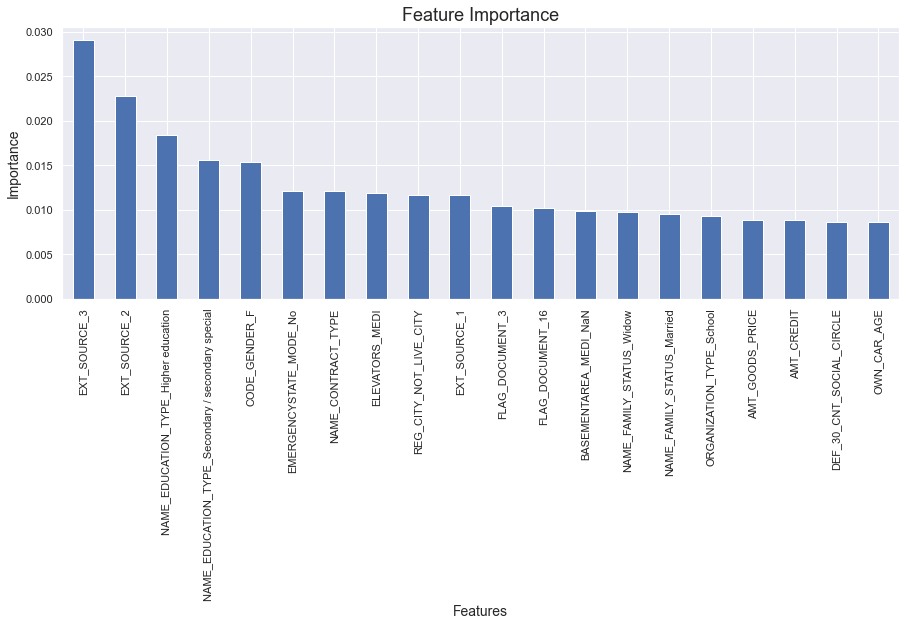

In [101]:
Importance = pd.DataFrame(model_xgbc['xgbclassifier'].feature_importances_, index = new_features, columns = ['Importance'])
plt.figure(figsize = (15,5))
Importance['Importance'].sort_values(ascending = False)[:20].plot.bar(y = 'Importance')
plt.title('Feature Importance', fontsize = 18)
plt.xlabel('Features', size = 14)
plt.ylabel('Importance', size = 14)
plt.show()

#### With Over Sampling

In [102]:
model_xgbc = make_pipeline(preprocessor, SelectFromModel(XGBClassifier()), XGBClassifier(random_state=42))

In [103]:
model_xgbc.fit(X_train_ros, Y_train_ros)
pred_11 = model_xgbc.predict_proba(X_test)
pred_11 = pred_11[:, 1]

[17:21:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:23:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [104]:
auc_11 = roc_auc_score(Y_test, pred_11)
print('AUC: ', auc_11)

AUC:  0.7473323918396331


In [105]:
pred_11_t = model_xgbc.predict_proba(X_train_ros)
pred_11_t = pred_11_t[:, 1]
auc_11_t = roc_auc_score(Y_train_ros, pred_11_t)
print('AUC: ', auc_11_t)

AUC:  0.855892861857094


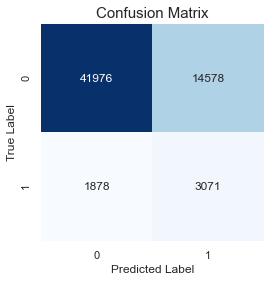

In [106]:
pred_test = model_xgbc.predict(X_test)
conf_matrix(Y_test, pred_test)

In [107]:
precision_11 = precision_score(Y_test, pred_test)
recall_11 = recall_score(Y_test, pred_test)

print('precision: ', precision_11)
print('recall: ', recall_11)

precision:  0.1740041928721174
recall:  0.6205293998787634


In [108]:
mask = model_xgbc['selectfrommodel'].get_support()
new_features = []

for bool, feature in zip(mask, get_column_names_from_ColumnTransformer(model_xgbc['columntransformer'])):
    if bool:
        new_features.append(feature)

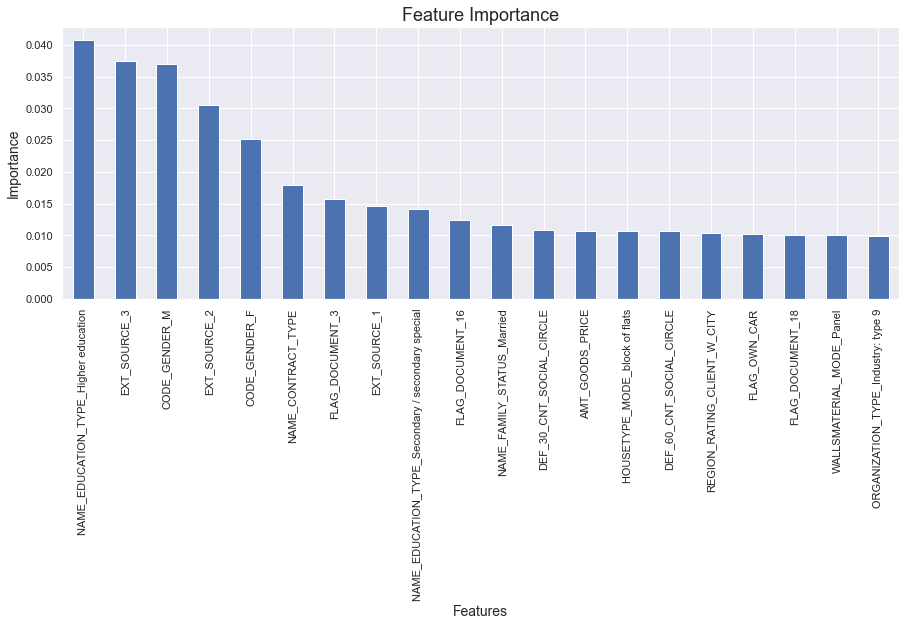

In [109]:
Importance = pd.DataFrame(model_xgbc['xgbclassifier'].feature_importances_, index = new_features, columns = ['Importance'])
plt.figure(figsize = (15,5))
Importance['Importance'].sort_values(ascending = False)[:20].plot.bar(y = 'Importance')
plt.title('Feature Importance', fontsize = 18)
plt.xlabel('Features', size = 14)
plt.ylabel('Importance', size = 14)
plt.show()

#### With SMOTE

In [110]:
model_xgbc = make_pipeline(SelectFromModel(XGBClassifier()), XGBClassifier(random_state=42))

In [111]:
model_xgbc.fit(X_train_smo, Y_train_smo)
pred_12 = model_xgbc.predict_proba(X_test_smo)
pred_12 = pred_12[:, 1]

[17:24:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:26:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [112]:
auc_12 = roc_auc_score(Y_test, pred_12)
print('AUC: ', auc_12)

AUC:  0.6246424389186294


In [113]:
pred_12_t = model_xgbc.predict_proba(X_train_smo)
pred_12_t = pred_12_t[:, 1]
auc_12_t = roc_auc_score(Y_train_smo, pred_12_t)
print('AUC: ', auc_12_t)

AUC:  0.9820242840341113


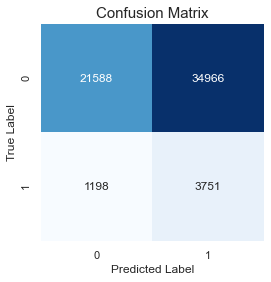

In [114]:
pred_test = model_xgbc.predict(X_test_smo)
conf_matrix(Y_test, pred_test)

In [115]:
precision_12 = precision_score(Y_test, pred_test)
recall_12 = recall_score(Y_test, pred_test)

print('precision: ', precision_12)
print('recall: ', recall_12)

precision:  0.09688250639254074
recall:  0.7579308951303294


In [116]:
mask = model_xgbc['selectfrommodel'].get_support()
new_features = []

for bool, feature in zip(mask, get_column_names_from_ColumnTransformer(preprocessor)):
    if bool:
        new_features.append(feature)

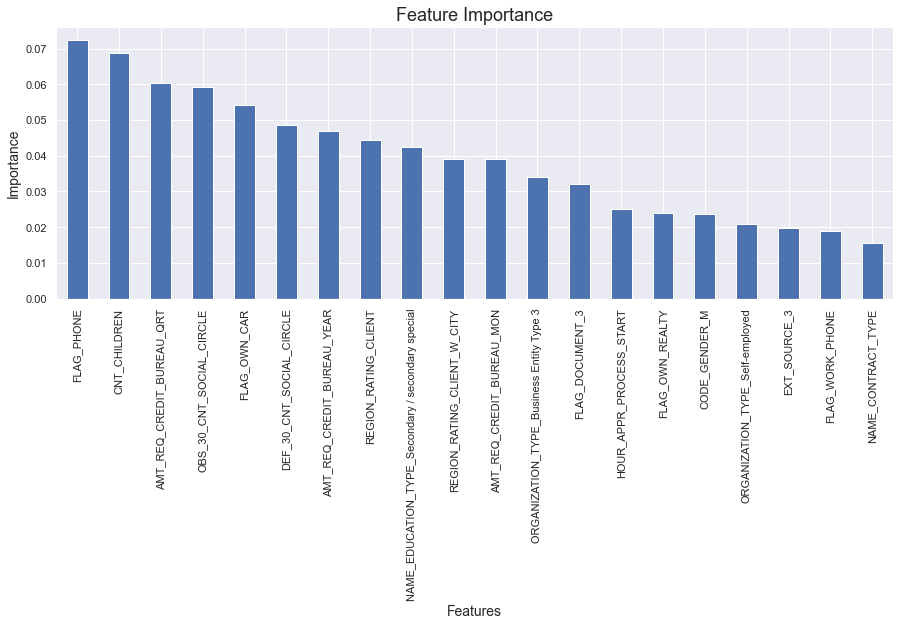

In [117]:
Importance = pd.DataFrame(model_xgbc['xgbclassifier'].feature_importances_, index = new_features, columns = ['Importance'])
plt.figure(figsize = (15,5))
Importance['Importance'].sort_values(ascending = False)[:20].plot.bar(y = 'Importance')
plt.title('Feature Importance', fontsize = 18)
plt.xlabel('Features', size = 14)
plt.ylabel('Importance', size = 14)
plt.show()

# 4. Results

In [118]:
model_name = ['Logistic Regression - RUS', 
              'Logistic Regression - ROS', 
              'Logistic Regression - SMOTE',
              'Random Forest Classifier - RUS',
              'Random Forest Classifier - ROS',
              'Random Forest Classifier - SMOTE',
              'LGBM Classifier - RUS',
              'LGBM Classifier - ROS',
              'LGBM Classifier - SMOTE',
              'XGB Classifier - RUS',
              'XGB Classifier - ROS',
              'XGB Classifier - SMOTE']

columns_name = ['AUC', 'AUC_Training', 'Precision', 'Recall']

df_result = pd.DataFrame(index = model_name, columns = columns_name)

In [119]:
count = 1
for i in model_name:
    df_result.loc[i, 'AUC'] = vars()['auc_' + str(count)]
    df_result.loc[i, 'AUC_Training'] = vars()['auc_' + str(count) + '_t']
    df_result.loc[i, 'Precision'] = vars()['precision_' + str(count)]
    df_result.loc[i, 'Recall'] = vars()['recall_' + str(count)]
    count = count + 1

In [120]:
df_result

,AUC,AUC_Training,Precision,Recall
Logistic Regression - RUS,0.746516,0.748021,0.157996,0.679935
Logistic Regression - ROS,0.747023,0.748262,0.158619,0.675086
Logistic Regression - SMOTE,0.729407,0.764578,0.147739,0.68135
Random Forest Classifier - RUS,0.737309,1,0.160921,0.662154
Random Forest Classifier - ROS,0.729758,1,0.429907,0.0185896
Random Forest Classifier - SMOTE,0.677884,1,0.185256,0.175187
LGBM Classifier - RUS,0.755243,0.818523,0.162866,0.689836
LGBM Classifier - ROS,0.759679,0.79707,0.168086,0.669832
LGBM Classifier - SMOTE,0.663605,0.97791,0.136514,0.501313
XGB Classifier - RUS,0.741175,0.898751,0.154897,0.673267
